
# CELL TRACK ANALYSIS

Code written by Mariona Colomer-Rosell


In [2]:
# LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
import numpy as np
import seaborn as sns
import csv
import locale
import csv
from statannot import add_stat_annotation
from matplotlib.lines import Line2D


# SETTING AND FORMAT
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

font = {'family' : 'normal',
        'weight' : 'normal'}

plt.rcParams['font.family'] = 'Helvetica'
#plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

#matplotlib.rc('font', **font)

## Common functions 

In [3]:
def positions(filename, pixel_conversion, length_threshold):
    """Extract the position coordinates from
    a file with a certain pixel conversion"""
    df1 = pd.read_csv(filename, encoding = "ISO-8859-1")
    num_cells = max(df1['Track n'].unique())
    x_pos = []
    y_pos = []
    for ml in range(max(df1['Track n'])+1):
        x_pos.append([])
        y_pos.append([])
    for i in range(len(df1['X'])):
        index = int(df1['Track n'][i])
        x_pos[index].append(pixel_conversion*(df1['X'][i]))
        y_pos[index].append(pixel_conversion*(df1['Y'][i]))
    
    #Remove tracks shorter than the legth_threshold
    x_pos_filter = []
    y_pos_filter = []
    
    for i in range(len(x_pos)):
        if (len(x_pos[i])>=(length_threshold-1)):
            x_pos_filter.append(x_pos[i])
            y_pos_filter.append(y_pos[i])
    num_cells = len(x_pos_filter)
    return x_pos_filter, y_pos_filter, num_cells

In [4]:
def positions(filename, pixel_conversion, length_threshold, cut_frames=0):
    """
    Extract the position coordinates from a file with a certain pixel conversion
    and cut the first X frames from each track.
    
    Parameters:
    - filename: Path to the file
    - pixel_conversion: Conversion factor for the pixel to actual position
    - length_threshold: Minimum number of frames for tracks to be kept
    - cut_frames: Number of initial frames to be cut from each track (default is 0)
    
    Returns:
    - x_pos_filter: List of filtered x positions
    - y_pos_filter: List of filtered y positions
    - num_cells: Number of remaining tracks
    """
    df1 = pd.read_csv(filename, encoding="ISO-8859-1")
    num_cells = max(df1['Track n'].unique())
    x_pos = []
    y_pos = []
    
    for ml in range(max(df1['Track n']) + 1):
        x_pos.append([])
        y_pos.append([])
    
    for i in range(len(df1['X'])):
        index = int(df1['Track n'][i])
        x_pos[index].append(pixel_conversion * (df1['X'][i]))
        y_pos[index].append(pixel_conversion * (df1['Y'][i]))
    
    # Remove tracks shorter than the length_threshold and apply the cut_frames
    x_pos_filter = []
    y_pos_filter = []
    
    for i in range(len(x_pos)):
        if len(x_pos[i]) >= length_threshold:
            x_cut = x_pos[i][cut_frames:]  # Cut the first X frames
            y_cut = y_pos[i][cut_frames:]  # Cut the first X frames
            x_pos_filter.append(x_cut)
            y_pos_filter.append(y_cut)
    
    num_cells = len(x_pos_filter)
    
    return x_pos_filter, y_pos_filter, num_cells


In [5]:
def create_dataframe(values, files, labels, name, condition):
    list_labels = []
    list_values = []
    list_conditions = [] 
    for i in range(len(files)):
        for j in range(len(values[i])):
            list_labels.append(labels[i]) 
            list_values.append(values[i][j])
            list_conditions.append(condition[i])
    df = pd.DataFrame(list(zip(list_labels, list_values, list_conditions)), columns = ['temperature',name, "condition"])
    return df

In [6]:
def create_dataframe_time(values, frames, files, labels, name, condition):
    list_labels = []
    list_values = []
    list_frames = []
    list_conditions = []
    for i in range(len(files)):
        for j in range(len(values[i])):
            list_labels.append(labels[i]) 
            list_values.append(values[i][j])
            list_frames.append(frames[i][j])
            list_conditions.append(condition[i])
    df = pd.DataFrame(list(zip(list_labels, list_values, list_frames, list_conditions)), columns = ['temperature',name, 'frame', "condition"])
    return df

## Analysis of parameters

### Average velocity

In [7]:
def average_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    velocity_list = []
    for cell in range(num_cells):
        cell_velocity = []

        if len(x_pos[cell])>= length_threshold:
            for i in range(length_threshold-period):
                x1 = x_pos[cell][i]
                x2 = x_pos[cell][i+period]
                y1 = y_pos[cell][i]
                y2 = y_pos[cell][i+period]
                velocity = (np.sqrt((x2-x1)**2+(y2-y1)**2))/period*time_conversion
                cell_velocity.append(velocity)
            velocity_list.append(np.average(cell_velocity))
    print(velocity_list)
    return velocity_list

def plot_average_velocity_condition(df_velocity, colors, cell_type):
    
            
    print(df_velocity.groupby(['temperature',"condition"])['velocity'].mean().reset_index(name='average'))
    print(df_velocity.groupby(['temperature', "condition"])['velocity'].std().reset_index(name='std'))
    print(df_velocity.groupby(['temperature', "condition"])['velocity'].size().reset_index(name='N'))

    customPalette = sns.set_palette(sns.color_palette([colors[0], colors[1]]))

    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="velocity", data = df_velocity,  hue="condition",
                     palette = customPalette, notch=True)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Average cell speed ($\mu m/min$)')

    medians = df_velocity.groupby(['temperature'])['velocity'].median().values
    nobs = df_velocity['temperature'].value_counts().sort_index().values
    print(df_velocity['temperature'].value_counts().sort_index())
    print(nobs)
    """
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["N= " + i for i in nobs]

    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], -2, nobs[tick],
        horizontalalignment='center', size='small', color='black')
    """
    ax.legend_.set_title(None)

    fig.savefig(cell_type+"_Velocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_Velocity.png", bbox_inches='tight', transparent=True)


In [8]:
def plot_average_velocity(df_velocity, colors, cell_type):
    
        
    print(df_velocity.groupby('temperature')['velocity'].mean().reset_index(name='average'))
    print(df_velocity.groupby('temperature')['velocity'].std().reset_index(name='std'))

    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(2,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="velocity", data = df_velocity,  palette = customPalette, notch=True)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Average cell speed ($\mu m/min$)')

    medians = df_velocity.groupby(['temperature'])['velocity'].median().values
    nobs = df_velocity['temperature'].value_counts().sort_index().values
    print(df_velocity['temperature'].value_counts().sort_index())
    print(nobs)
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["N= " + i for i in nobs]
    plt.ylim(-3,12)

    """
    add_stat_annotation(ax, data=data_i, x="Temperature", y="Velocity",
                    box_pairs=[(temperatures[0], temperatures[1]),(temperatures[1], temperatures[2])],text_annot_custom=significant_bars[i],
                                   pvalues=[0,0], loc="inside",perform_stat_test=False,line_height=0.0,line_offset_to_box=0.1)
"""
    
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], -2, nobs[tick],
        horizontalalignment='center', size='small', color='black')
    fig.savefig(cell_type+"_Velocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_Velocity.png", bbox_inches='tight', transparent=True)


### Instant velocity

In [9]:
def instant_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    inst_velocity_list = []
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            for i in range((length_threshold-period)//period):
                x1 = x_pos[cell][period*i]
                x2 = x_pos[cell][period*(i+1)]
                y1 = y_pos[cell][period*i]
                y2 = y_pos[cell][period*(i+1)]
                velocity = (np.sqrt((x2-x1)**2+(y2-y1)**2))/period*time_conversion
                inst_velocity_list.append(velocity)
                frames_list.append(i/period*time_conversion)
    return inst_velocity_list, frames_list

def plot_instant_velocity(df_instant, colors, cell_type, length_threshold=100):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.lineplot(x="frame", y ="INST_Vel", ci=68, data = df_instant, hue="temperature", palette = customPalette, err_style="bars")
    plt.xlabel('time (min)')
    plt.ylabel('Instantaneous speed ($\mu m/min$ )')
    plt.legend('',frameon=False)
    plt.xlim(1,max(df_instant.frame))
    fig.savefig(cell_type+"_InstVelocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_InstVelocity.png", bbox_inches='tight', transparent=True)


def plot_instant_velocity_condition(df_instant, colors, cell_type, length_threshold=100):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    
    conditions = df_instant["condition"].unique()
    print(conditions)
    for i in range(len(conditions)):
        df = df_instant[df_instant["condition"] == conditions[i]]
        ax = sns.lineplot(x="frame", y ="INST_Vel", data = df, 
                          style = "temperature", err_style=None, color = colors[i], linewidth=2)

    plt.xlabel('time (min)')
    plt.ylabel('Instantaneous speed ($\mu m/min$ )')
    custom_lines = [Line2D([0], [0], color=colors[0], linestyle="-",lw=2),
                    Line2D([0], [0], color=colors[0],linestyle="--", lw=2),
                    Line2D([0], [0], color=colors[1], linestyle="-",lw=2),
                    Line2D([0], [0], color=colors[1],linestyle="--", lw=2)]

    plt.legend(custom_lines, ['25ºC '+conditions[0], '40ºC '+conditions[0],'25ºC '+conditions[1], '40ºC '+conditions[1]], bbox_to_anchor=(1, 0.5))
    plt.xlim(1,max(df_instant.frame))
    fig.savefig(cell_type+"_InstVelocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_InstVelocity.png", bbox_inches='tight', transparent=True)


### Segment velocity

In [10]:
def plot_segment_velocity(df_velocity, colors, cell_type):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="SEGMENT_velocity", data = df_velocity,  palette = customPalette, notch=True,showfliers= False)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Average cell speed ($\mu m/min$)')

    medians = df_velocity.groupby(['temperature'])['SEGMENT_velocity'].median().values
    nobs = df_velocity['temperature'].value_counts().sort_index().values
    print(df_velocity['temperature'].value_counts().sort_index())

    fig.savefig(cell_type+"_SEGMENTVelocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_SEGMENTVelocity.png", bbox_inches='tight', transparent=True)


In [11]:
def plot_segment_velocity_condition(df_velocity, colors, cell_type):

    fig = plt.figure(figsize=(4,4))
    customPalette = sns.set_palette(sns.color_palette([colors[0], colors[1]]))

    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="SEGMENT_velocity", data = df_velocity, hue="condition",
                     palette = customPalette, notch=True,showfliers= False)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Speed ($\mu m/min$)')

    medians = df_velocity.groupby(['temperature'])['SEGMENT_velocity'].median().values
    nobs = df_velocity['temperature'].value_counts().sort_index().values
    print(df_velocity['temperature'].value_counts().sort_index())
    ax.legend_.set_title(None)

    fig.savefig(cell_type+"_SEGMENTVelocity.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_SEGMENTVelocity.png", bbox_inches='tight', transparent=True)


### Euclidean distance

In [12]:
def euclidean_distance(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    euc_distance_list = []
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            for i in range(1+(length_threshold-period)//period):
                x0 = x_pos[cell][0]
                x2 = x_pos[cell][period*(i)]
                y0 = y_pos[cell][0]
                y2 = y_pos[cell][period*(i)]
                distance = (np.sqrt((x2-x0)**2+(y2-y0)**2))
                euc_distance_list.append(distance)
                frames_list.append(i/period*time_conversion)
    return euc_distance_list, frames_list

def plot_euclidean_distance(df_instant, colors, cell_type, length_threshold):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.lineplot(x="frame", y ="EUC_Dis", ci=68, data = df_instant, 
                      hue="temperature", palette = customPalette, err_style="bars")
    ax = sns.lineplot(x="frame", y ="EUC_Dis", ci=68, data = df_instant, 
                      hue="temperature", palette = customPalette)
    plt.xlabel('time (min)')
    plt.ylabel('$d_{euc}$ ($\mu m$)')
    plt.legend('',frameon=False)
    plt.xlim(0,length_threshold-1)
    fig.savefig(cell_type+"_EucDistance.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_EucDistance.png", bbox_inches='tight', transparent=True)


### Chemotactic index

In [13]:
def chemotactic_index_time(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    CI_list = []
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            total_dis = 0
            for i in range(length_threshold-1):
                x0 = x_pos[cell][0]
                x1 = x_pos[cell][i]
                x2 = x_pos[cell][i+1]
                y0 = y_pos[cell][0]
                y1 = y_pos[cell][i]
                y2 = y_pos[cell][i+1]
                total_dis = total_dis + np.sqrt((x2-x1)**2+(y2-y1)**2)
            euc_dis = np.sqrt((x2-x0)**2+(y2-y0)**2)
            CI_list.append(euc_dis/total_dis)
            frames_list.append(i)
    return CI_list, frames_list


def chemotactic_index(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    CI_list = []
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            total_dis = 0
            for i in range(length_threshold-1):
                x0 = x_pos[cell][0]
                x1 = x_pos[cell][i]
                x2 = x_pos[cell][i+1]
                y0 = y_pos[cell][0]
                y1 = y_pos[cell][i]
                y2 = y_pos[cell][i+1]
                euc_dis = np.sqrt((x2-x0)**2+(y2-y0)**2)
                total_dis = total_dis + np.sqrt((x2-x1)**2+(y2-y1)**2)
            if total_dis != 0:
                CI_list.append(euc_dis/total_dis)
                frames_list.append(i)
    return CI_list, frames_list


def plot_chemotactic_index_line(df_CI, colors, cell_type):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.lineplot(x="frame", y ="CI", data = df_CI,  hue="temperature", 
                      palette = customPalette, err_style="bars")
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Chemotatic Index (a.u.)')
    plt.legend('',frameon=False)
    fig.savefig(cell_type+"_CI_lineplot.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_CI_lineplot.png", bbox_inches='tight', transparent=True)

    
def plot_chemotactic_index(df_CI, colors, cell_type):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="CI", data = df_CI,  palette = customPalette, notch=True)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Chemotatic Index (a.u.)')
    #plt.legend('',frameon=False)
    plt.ylim(0,1.5)
    fig.savefig(cell_type+"_CI.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_CI.png", bbox_inches='tight', transparent=True)
    
def plot_chemotactic_index_condition_boxplot(df_CI, colors, cell_type):
    customPalette = sns.set_palette(sns.color_palette([colors[0], colors[1]]))
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.boxplot(x="temperature", y ="CI", data = df_CI, hue="condition", palette = customPalette, notch=True)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Chemotatic Index (a.u.)')
    plt.ylim(0,1.5)
    #plt.legend('',frameon=False)
    ax.legend_.set_title(None)
    fig.savefig(cell_type+"_CI_boxplot.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_CI_boxplot.png", bbox_inches='tight', transparent=True)

def plot_chemotactic_index_condition_barplot(df_CI, colors, cell_type):

    print("CI")
    print(df_CI.groupby(['temperature',"condition"])['CI'].mean().reset_index(name='average'))
    print(df_CI.groupby(['temperature', "condition"])['CI'].std().reset_index(name='std'))
    print(df_CI.groupby(['temperature', "condition"])['CI'].size().reset_index(name='N'))

    customPalette = sns.set_palette(sns.color_palette(['grey', 'mediumaquamarine']))
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.barplot(x="temperature", y ="CI", data = df_CI, hue="condition", palette = customPalette)
    plt.xlabel('Temperature (ºC)')
    plt.ylabel('Chemotatic Index (a.u.)')
    #plt.legend('',frameon=False)
    plt.ylim(0,1)
    ax.legend_.set_title(None)
    fig.savefig(cell_type+"_CI_barplot.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_CI_barplot.png", bbox_inches='tight', transparent=True)


### MSD

In [14]:
def MSD(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    MSD_list = []
    frames = np.arange(0,length_threshold//2,1)
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            for m in frames:
                displacement = []
                for i in range(length_threshold-m):
                    x1 = x_pos[cell][i]
                    x2 = x_pos[cell][i+m]
                    y1 = y_pos[cell][i]
                    y2 = y_pos[cell][i+m]
                    distance = (x2-x1)**2+(y2-y1)**2
                    displacement.append(distance)
                MSD_list.append(np.average(displacement))
                frames_list.append(m/time_conversion)
    return MSD_list, frames_list

In [15]:
def plot_MSD_condition(df_MSD, colors, cell_type):
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    conditions = df_MSD["condition"].unique()
    print(conditions)
    for i in range(len(conditions)):
        df = df_MSD[df_MSD["condition"] == conditions[i]]
        ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df, 
                          style = "temperature", err_style=None, color = colors[i], linewidth=2)
    plt.xlabel('Time lag ($min$)')
    plt.ylabel('MSD ($\mu m^{2}$)')

    custom_lines = [Line2D([0], [0], color=colors[0], linestyle="-",lw=2),
                    Line2D([0], [0], color=colors[0],linestyle="--", lw=2),
                    Line2D([0], [0], color=colors[1], linestyle="-",lw=2),
                    Line2D([0], [0], color=colors[1],linestyle="--", lw=2)]

    plt.legend(custom_lines, ['25ºC ctrl', '40ºC ctrl','25ºC '+conditions[1], '40ºC '+conditions[1]])

    #plt.legend('',frameon=False)
    #plt.xlim(0,10)
    #plt.ylim(-200, 4500)
    fig.savefig(cell_type+"_MSD.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_MSD.png", bbox_inches='tight', transparent=True)


In [16]:
def plot_MSD(df_MSD, colors, cell_type):
    customPalette = sns.set_palette(sns.color_palette(colors))
    fig = plt.figure(figsize=(4,4))
    sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})
    ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df_MSD, hue="temperature", 
                      palette = customPalette, err_style = None)
    plt.xlabel('Time lag ($min$)')
    plt.ylabel('MSD ($\mu m^{2}$)')
    plt.legend('',frameon=False)
    plt.xlim(0,10)
    plt.ylim(-200, 4500)
    fig.savefig(cell_type+"_MSD.svg", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_MSD.png", bbox_inches='tight', transparent=True)


### Tracks

In [17]:
def get_tracks(x_pos, y_pos, num_cells, length_threshold, file):
    random_tracks = np.linspace(0, len(x_pos)-1, 20, dtype=int)
    random_indices = []
    random_cells = []
    random_x_pos = []
    random_y_pos = []
    for cell in random_tracks:
        for i in range(len(x_pos[cell])):
            random_cells.append(cell)
            random_x_pos.append(x_pos[cell][i]-x_pos[cell][0])
            random_y_pos.append(y_pos[cell][i]-y_pos[cell][0])

    df = pd.DataFrame(list(zip(random_cells, random_x_pos,random_y_pos)), columns =['cell', 'x-x_0', 'y-y_0']) 
    df.to_csv("RandomTracks.csv", index=False)


In [18]:
def plot_tracks(files, colors, cell_type):
    """Compute the average velocity of a set of tracks"""
    fig = plt.figure(figsize=(6,4))    
    for file in [2,0]:
        df = pd.read_csv("RandomTracks_"+files[file])
        for i in df['cell'].unique():
            df_i = df[df['cell']== i]
            plt.plot(df_i["x-x_0"], df_i["y-y_0"], c= colors[file], linewidth=2, alpha=0.7)
    
    plt.xlabel('$x-x_0$ ($\mu m$)')
    plt.ylabel('$y-y_0$ ($\mu m$)')
    plt.xlim(-200,400)
    plt.ylim(-200,200)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.grid(b=True,color='lightgrey', linestyle='-', linewidth=0.5)
    fig.savefig(cell_type+"_TRACKSPlot.png", bbox_inches='tight', transparent=True)
    fig.savefig(cell_type+"_TRACKSPlot.svg", bbox_inches='tight', transparent=True)

    return

## Ridge plot

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_ridge_average_velocity_condition(df_velocity, colors, cell_type):
    
    # Print summary statistics
    print(df_velocity.groupby(['temperature', "condition"])['velocity'].mean().reset_index(name='average'))
    print(df_velocity.groupby(['temperature', "condition"])['velocity'].std().reset_index(name='std'))
    print(df_velocity.groupby(['temperature', "condition"])['velocity'].size().reset_index(name='N'))

    # Create a custom palette
    customPalette = sns.color_palette([colors[0], colors[1]])

    # Create the ridge plot (Joy plot)
    g = sns.FacetGrid(df_velocity, row="temperature", hue="condition", aspect=4, height=1.5, palette=customPalette)
    g.map(sns.kdeplot, "velocity", fill=True, alpha=0.7)
    
    # Set plot labels and formatting
    g.set_titles("{row_name}ºC")
    g.set_xlabels('Average cell speed ($\mu m/min$)')
    g.set_ylabels('')
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # Set x-axis limits to avoid negative values
    g.set(xlim=(0, None))  # Ensures that x-axis starts at 0
    
    # Add legend
    g.add_legend()

    # Save figure
    g.fig.savefig(cell_type + "_Velocity_RidgePlot.svg", bbox_inches='tight', transparent=True)
    g.fig.savefig(cell_type + "_Velocity_RidgePlot.png", bbox_inches='tight', transparent=True)

# Example usage of the function would be the same as for your original boxplot


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_ridge_overlay_velocity(df_velocity, colors, cell_type):
    """
    Generate an overlay ridge plot for all temperature groups on the same line.
    Each temperature group will have a different color.
    """
    
    # Print summary statistics
    print(df_velocity.groupby(['temperature'])['velocity'].mean().reset_index(name='average'))
    print(df_velocity.groupby(['temperature'])['velocity'].std().reset_index(name='std'))
    print(df_velocity.groupby(['temperature'])['velocity'].size().reset_index(name='N'))

    # Create a custom palette for the temperature groups
    unique_temperatures = sorted(df_velocity['temperature'].unique())
    palette = sns.color_palette("coolwarm", len(unique_temperatures))

    # Initialize figure
    plt.figure(figsize=(6, 4))
    
    # Loop through each temperature group and plot the density on the same plot
    for i, temp in enumerate(unique_temperatures):
        subset = df_velocity[df_velocity['temperature'] == temp]
        sns.kdeplot(subset['velocity'], fill=True, label=f"{temp}ºC", color=palette[i], alpha=0.6)

    # Set plot labels and legend
    plt.xlabel('Average cell speed ($\mu m/min$)')
    plt.ylabel('Density')
    plt.title(f'{cell_type} Velocity Distribution Across Temperatures')
    plt.legend(title="Temperature (ºC)")
    
    # Set x-axis limits to avoid negative values
    plt.xlim(0, None)  # Ensures x-axis starts at 0

    # Save figure
    plt.savefig(cell_type + "_Velocity_OverlayRidgePlot.svg", bbox_inches='tight', transparent=True)
    plt.savefig(cell_type + "_Velocity_OverlayRidgePlot.png", bbox_inches='tight', transparent=True)

    plt.show()

# Example usage:
# plot_ridge_overlay_velocity(df_velocity, colors, cell_type)


# Example usage:
# plot_ridge_average_velocity(df_velocity, colors, cell_type)


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_ridge_overlay_velocity_2(df_velocity, colors, cell_type):
    """
    Generate an overlay ridge plot for all temperature groups on the same line.
    Each temperature group will have a different color.
    """
    
    # Print summary statistics
    print(df_velocity.groupby(['temperature'])['velocity'].mean().reset_index(name='average'))
    print(df_velocity.groupby(['temperature'])['velocity'].std().reset_index(name='std'))
    print(df_velocity.groupby(['temperature'])['velocity'].size().reset_index(name='N'))

    # Create a custom palette for the temperature groups
    unique_temperatures = sorted(df_velocity['temperature'].unique())
    palette = sns.color_palette("coolwarm", len(unique_temperatures))

    # Initialize figure
    plt.figure(figsize=(6, 4))
    
    # Loop through each temperature group and plot the density on the same plot
    for i, temp in enumerate(unique_temperatures):
        subset = df_velocity[df_velocity['temperature'] == temp]
        sns.kdeplot(subset['velocity'], fill=True, label=f"{temp}ºC", color=palette[i], alpha=0.6)

    # Set plot labels and legend
    plt.xlabel('Average cell speed ($\mu m/min$)')
    plt.ylabel('Density')
    plt.title(f'{cell_type} Velocity Distribution Across Temperatures')
    plt.legend(title="Temperature (ºC)")
    
    # Set x-axis limits to avoid negative values
    plt.xlim(0, None)  # Ensures x-axis starts at 0

    # Save figure
    plt.savefig(cell_type + "_Velocity_OverlayRidgePlot.svg", bbox_inches='tight', transparent=True)
    plt.savefig(cell_type + "_Velocity_OverlayRidgePlot.png", bbox_inches='tight', transparent=True)

    plt.show()

# Example usage:
# plot_ridge_overlay_velocity(df_velocity, colors, cell_type)



## Main program

In [20]:
def main(files, labels, colors, cell_type, length_threshold, period, pixel_conversion, time_conversion):
    """Main program for computing the features and making the plots"""
    files_velocity = []
    files_inst_velocity = []
    files_euc_distance = []
    files_MSD = []
    files_CI = []
    frames_euc_list = []
    frames = []
    frames_MSD_list = []
    frames_CI_list = []
    for file in range(len(files)):
        x_pos, y_pos, num_cells = positions(files[file], pixel_conversion, length_threshold)
        label = labels[file]
        color = colors[file]
        velocity = average_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        inst_velocity, frames_list = instant_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        files_velocity.append(velocity)
        files_inst_velocity.append(inst_velocity)
        frames.append(frames_list)
        euc_distance, frames_euc = euclidean_distance(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        files_euc_distance.append(euc_distance)
        frames_euc_list.append(frames_euc)
        get_tracks(x_pos, y_pos, num_cells, length_threshold, files[file])
        MSD_list, frames_MSD = MSD(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        files_MSD.append(MSD_list)
        frames_MSD_list.append(frames_MSD)
        CI, frames_CI = chemotactic_index(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        frames_CI_list.append(frames_CI)
        files_CI.append(CI)
        
    df_velocity = create_dataframe(files_velocity, files, labels, "velocity",labels)
    df_segment_velocity = create_dataframe(files_inst_velocity, files, labels, "SEGMENT_velocity",labels)
    df_inst_velocity = create_dataframe_time(files_inst_velocity, frames, files, labels, "INST_Vel",labels)
    print(df_inst_velocity.head)
    df_euc_distance = create_dataframe_time(files_euc_distance, frames_euc_list, files, labels, "EUC_Dis",labels)
    df_MSD = create_dataframe_time(files_MSD, frames_MSD_list, files, labels, "MSD",labels)
    df_CI= create_dataframe_time(files_CI, frames_CI_list, files, labels, "CI",labels)

    plot_average_velocity(df_velocity, colors, cell_type)
    plot_instant_velocity(df_inst_velocity, colors, cell_type, length_threshold)
    plot_segment_velocity(df_segment_velocity, colors, cell_type)
    plot_euclidean_distance(df_euc_distance, colors, cell_type, length_threshold)
    #plot_tracks(files, colors, cell_type)
    print(df_MSD)
    plot_MSD(df_MSD, colors, cell_type)
    plot_chemotactic_index_line(df_CI, colors, cell_type)
    plot_chemotactic_index(df_CI, colors, cell_type)
    plot_ridge_average_velocity(df_velocity, colors, cell_type)

    plot_ridge_average_velocity_2(df_velocity, colors, cell_type)

In [21]:

def main_condition(files, labels, colors, cell_type, 
                   length_threshold, period, pixel_conversion, time_conversion, conditions,cut_frames):
    files_velocity = []
    files_inst_velocity = []
    files_euc_distance = []
    files_MSD = []
    files_CI = []
    frames_euc_list = []
    frames = []
    frames_MSD_list = []
    frames_CI_list = []
    for file in range(len(files)):
        x_pos, y_pos, num_cells = positions(files[file], pixel_conversion, length_threshold,cut_frames)
        label = labels[file]
        color = colors[file]
        velocity = average_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        inst_velocity, frames_list = instant_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        files_velocity.append(velocity)
        files_inst_velocity.append(inst_velocity)
        frames.append(frames_list)
        MSD_list, frames_MSD = MSD(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        files_MSD.append(MSD_list)
        frames_MSD_list.append(frames_MSD)
        CI, frames_CI = chemotactic_index_time(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)
        frames_CI_list.append(frames_CI)
        files_CI.append(CI)
        
    df_velocity = create_dataframe(files_velocity, files, labels, "velocity", conditions)
    print(df_velocity)
    df_segment_velocity = create_dataframe(files_inst_velocity, files, labels, "SEGMENT_velocity", conditions)
    df_MSD = create_dataframe_time(files_MSD, frames_MSD_list, files, labels, "MSD", conditions)
    df_CI= create_dataframe_time(files_CI, frames_CI_list, files, labels, "CI",conditions)

    df_inst_velocity = create_dataframe_time(files_inst_velocity, frames, files, labels, "INST_Vel",conditions)
    print("Dataframe inst velocity")
    print(df_inst_velocity.head())

    plot_average_velocity_condition(df_velocity, colors, cell_type)
    plot_instant_velocity_condition(df_inst_velocity, colors, cell_type)
    plot_segment_velocity_condition(df_segment_velocity, colors, cell_type)
    #plot_euclidean_distance(df_euc_distance, colors, cell_type)
    #plot_tracks(files, colors, cell_type)
    #print(df_MSD)
    plot_MSD_condition(df_MSD, colors, cell_type)
    #plot_chemotactic_index_line(df_CI, colors, cell_type)
    plot_chemotactic_index_condition_boxplot(df_CI, colors, cell_type)
    plot_chemotactic_index_condition_barplot(df_CI, colors, cell_type)
    plot_ridge_average_velocity_condition(df_velocity, colors, cell_type)
    return 0

## Make plots

[0.4734165192158796, 0.21733213690560121, 0.32728198047770324, 0.2623817511548129, 0.2611237317721426, 0.2261893896448347, 0.2715164379340359, 0.2663715338791595, 0.09077165706620473, 0.41976467065700274, 0.3269429893916948, 0.3652159997106036, 0.3733217646564457, 0.40430777245472044, 0.34450221854772783, 0.5271469346773676, 0.9612560856133624, 0.2882017716876889, 0.15345168355591818, 1.255749002573434, 0.26349118775570546, 0.3752443835061644, 0.0992648331197453, 0.9259393048753706, 1.0734385506497688]
[0.7112382802826144, 2.2202071636373053, 1.2902515522149312, 1.5992332347389875, 2.324816700826667, 0.5520292483451336, 0.12760098953128796, 2.7327148594826434, 2.352446745220857, 1.6203642190619703, 2.177426711187672, 1.3494882050689194, 0.41992729274047086, 1.6796120192638857, 0.4991905879433418, 1.4708881885998366, 0.509092093870823, 0.8105277293061924, 1.1450154917950524, 1.6025611847319874, 2.2596332720729824, 1.5326903599964743, 1.2353921930110674, 1.5058281261778612, 1.87067642644

/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,
/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,


CI
  temperature condition   average
0          25       AMA  0.493309
1          25      DMSO  0.416530
2          41       AMA  0.294209
3          41      DMSO  0.283602
  temperature condition       std
0          25       AMA  0.255703
1          25      DMSO  0.167103
2          41       AMA  0.181746
3          41      DMSO  0.196216
  temperature condition   N
0          25       AMA  26
1          25      DMSO  25
2          41       AMA  83
3          41      DMSO  57
  temperature condition   average
0          25       AMA  0.406097
1          25      DMSO  0.422145
2          41       AMA  1.805161
3          41      DMSO  1.681197
  temperature condition       std
0          25       AMA  0.344568
1          25      DMSO  0.303970
2          41       AMA  1.049718
3          41      DMSO  1.153926
  temperature condition   N
0          25       AMA  26
1          25      DMSO  25
2          41       AMA  83
3          41      DMSO  57


0

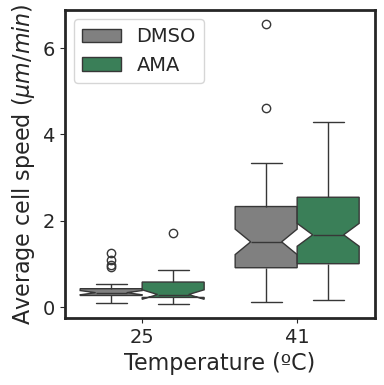

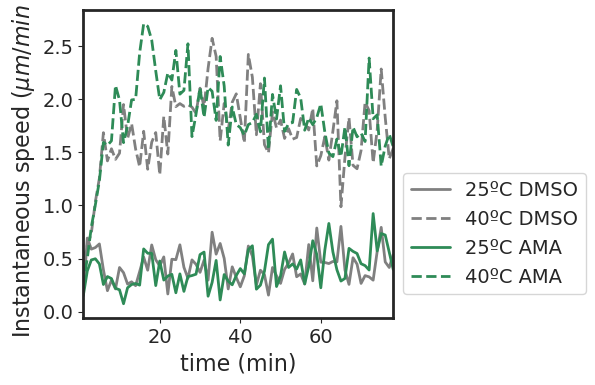

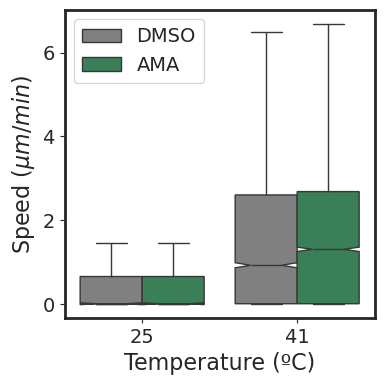

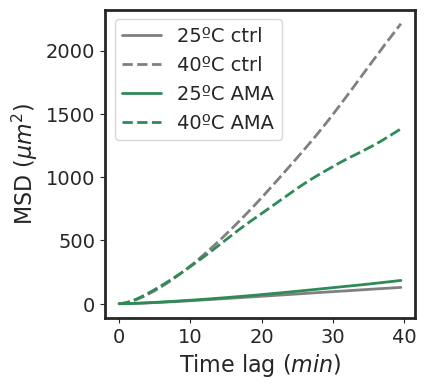

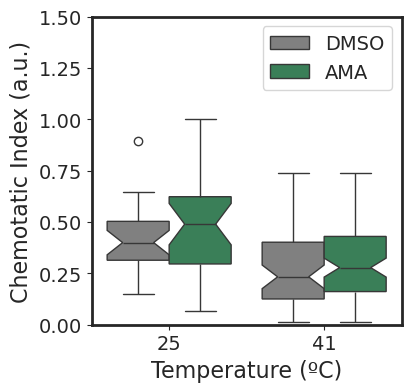

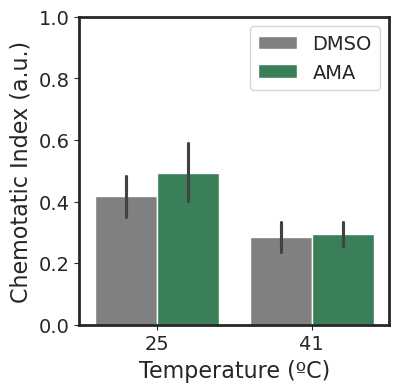

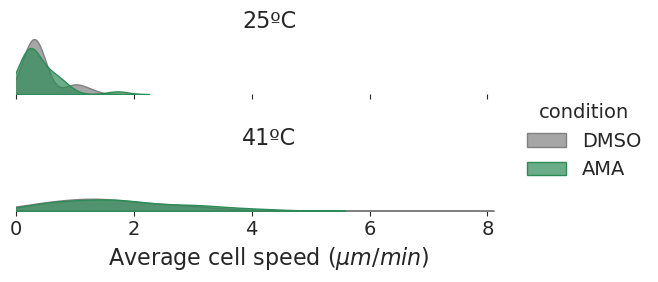

In [32]:
#SETTING THE FILES THAT WE WANT TO ANALYSE
path = ""
files = ["25_C_DMSO.csv","41_C_DMSO.csv",
         "25_C_AMA.csv","41_C_AMA.csv"]
conditions = ["DMSO", "DMSO", 'AMA', "AMA"]


files= ["Merged_Data/"+file for file in files]

labels = ['25', "41", "25", "41"]
colors = ['grey', 'seagreen','grey', 'seagreen']
pixel_conversion = 0.65
length_threshold = 160
period = 2
time_conversion = 2
cut_frames  = 0

#CALLING THE FUNCTION
main_condition(files, labels, colors, "AMA_0_80min", length_threshold, period, 
               pixel_conversion, time_conversion, conditions,cut_frames)

[0.4734165192158796, 0.21733213690560121, 0.32728198047770324, 0.2623817511548129, 0.2611237317721426, 0.2261893896448347, 0.2715164379340359, 0.2663715338791595, 0.09077165706620473, 0.41976467065700274, 0.3269429893916948, 0.3652159997106036, 0.3733217646564457, 0.40430777245472044, 0.34450221854772783, 0.5271469346773676, 0.9612560856133624, 0.2882017716876889, 0.15345168355591818, 1.255749002573434, 0.26349118775570546, 0.3752443835061644, 0.0992648331197453, 0.9259393048753706, 1.0734385506497688]
[0.7112382802826144, 2.2202071636373053, 1.2902515522149312, 1.5992332347389875, 2.324816700826667, 0.5520292483451336, 0.12760098953128796, 2.7327148594826434, 2.352446745220857, 1.6203642190619703, 2.177426711187672, 1.3494882050689194, 0.41992729274047086, 1.6796120192638857, 0.4991905879433418, 1.4708881885998366, 0.509092093870823, 0.8105277293061924, 1.1450154917950524, 1.6025611847319874, 2.2596332720729824, 1.5326903599964743, 1.2353921930110674, 1.5058281261778612, 1.87067642644

/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,
/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,


CI
  temperature condition   average
0          25     17AAG  0.367931
1          25      DMSO  0.416530
2          41     17AAG  0.341227
3          41      DMSO  0.283602
  temperature condition       std
0          25     17AAG  0.215738
1          25      DMSO  0.167103
2          41     17AAG  0.247892
3          41      DMSO  0.196216
  temperature condition   N
0          25     17AAG  24
1          25      DMSO  25
2          41     17AAG  29
3          41      DMSO  57
  temperature condition   average
0          25     17AAG  0.364929
1          25      DMSO  0.422145
2          41     17AAG  1.795980
3          41      DMSO  1.681197
  temperature condition       std
0          25     17AAG  0.345370
1          25      DMSO  0.303970
2          41     17AAG  1.544243
3          41      DMSO  1.153926
  temperature condition   N
0          25     17AAG  24
1          25      DMSO  25
2          41     17AAG  29
3          41      DMSO  57


0

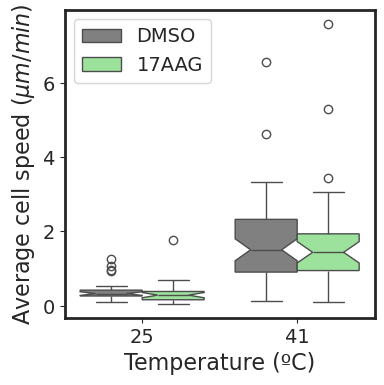

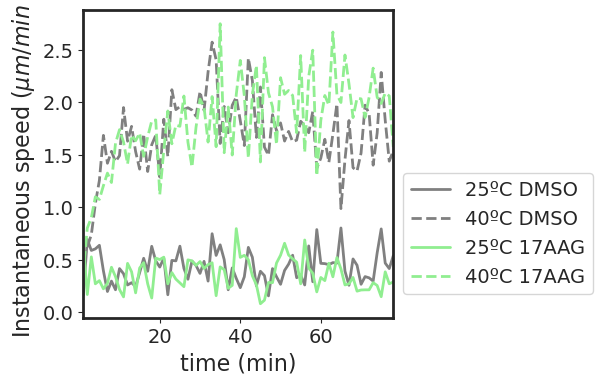

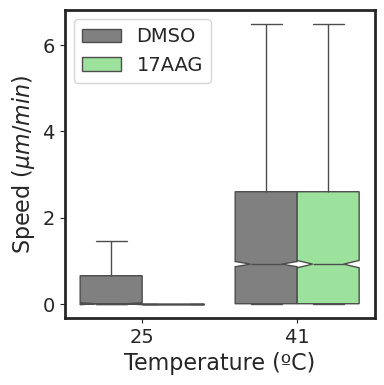

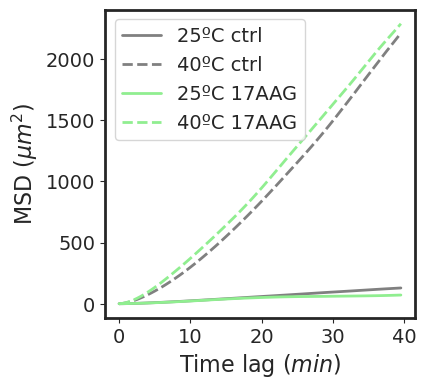

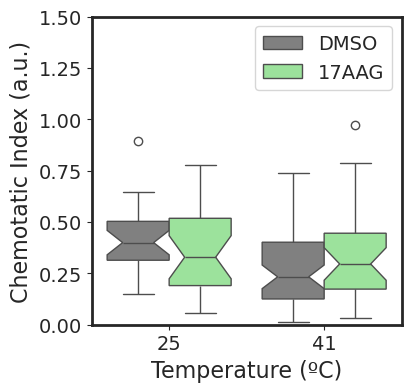

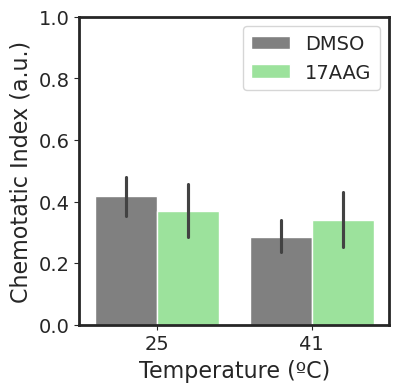

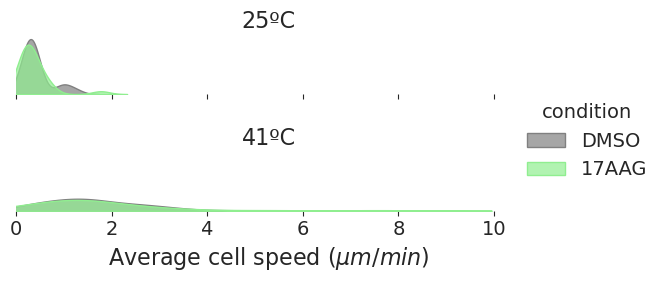

In [33]:
#SETTING THE FILES THAT WE WANT TO ANALYSE
path = ""
files = ["25_C_DMSO.csv","41_C_DMSO.csv",
         "25_C_17AAG.csv","41_C_17AAG.csv"]

files= ["Merged_Data/"+file for file in files]

conditions = ["DMSO", "DMSO", '17AAG', "17AAG"]

labels = ['25', "41", "25", "41"]
colors = ['grey', 'lightgreen','grey', 'lightgreen']
pixel_conversion = 0.65
length_threshold = 160
period = 2
time_conversion = 2
cut_frames = 0

#CALLING THE FUNCTION
main_condition(files, labels, colors, "17AAG_0_80min", length_threshold, period, 
               pixel_conversion, time_conversion, conditions,cut_frames)

[0.4734165192158796, 0.21733213690560121, 0.32728198047770324, 0.2623817511548129, 0.2611237317721426, 0.2261893896448347, 0.2715164379340359, 0.2663715338791595, 0.09077165706620473, 0.41976467065700274, 0.3269429893916948, 0.3652159997106036, 0.3733217646564457, 0.40430777245472044, 0.34450221854772783, 0.5271469346773676, 0.9612560856133624, 0.2882017716876889, 0.15345168355591818, 1.255749002573434, 0.26349118775570546, 0.3752443835061644, 0.0992648331197453, 0.9259393048753706, 1.0734385506497688]
[0.7112382802826144, 2.2202071636373053, 1.2902515522149312, 1.5992332347389875, 2.324816700826667, 0.5520292483451336, 0.12760098953128796, 2.7327148594826434, 2.352446745220857, 1.6203642190619703, 2.177426711187672, 1.3494882050689194, 0.41992729274047086, 1.6796120192638857, 0.4991905879433418, 1.4708881885998366, 0.509092093870823, 0.8105277293061924, 1.1450154917950524, 1.6025611847319874, 2.2596332720729824, 1.5326903599964743, 1.2353921930110674, 1.5058281261778612, 1.87067642644

/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,
/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,


CI
  temperature condition   average
0          25     CK666  0.501317
1          25      DMSO  0.416530
2          41     CK666  0.393838
3          41      DMSO  0.283602
  temperature condition       std
0          25     CK666  0.263083
1          25      DMSO  0.167103
2          41     CK666  0.241393
3          41      DMSO  0.196216
  temperature condition   N
0          25     CK666  48
1          25      DMSO  25
2          41     CK666  42
3          41      DMSO  57
  temperature condition   average
0          25     CK666  0.194358
1          25      DMSO  0.422145
2          41     CK666  1.809098
3          41      DMSO  1.681197
  temperature condition       std
0          25     CK666  0.180658
1          25      DMSO  0.303970
2          41     CK666  1.319807
3          41      DMSO  1.153926
  temperature condition   N
0          25     CK666  48
1          25      DMSO  25
2          41     CK666  42
3          41      DMSO  57


0

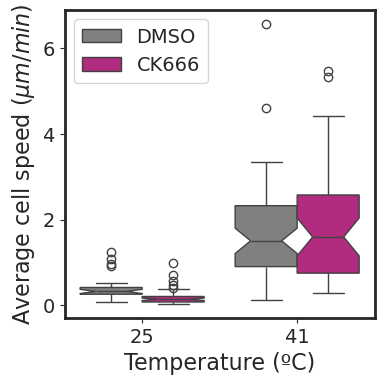

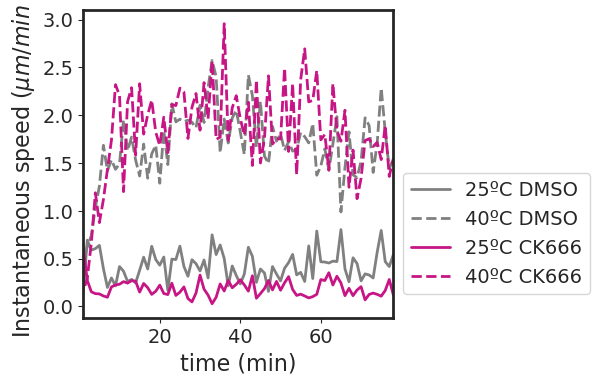

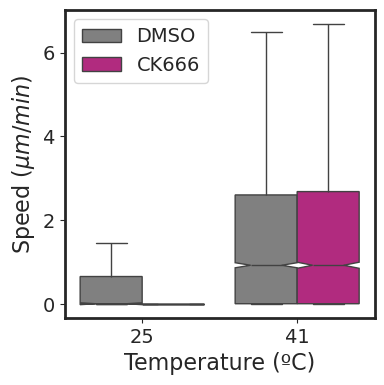

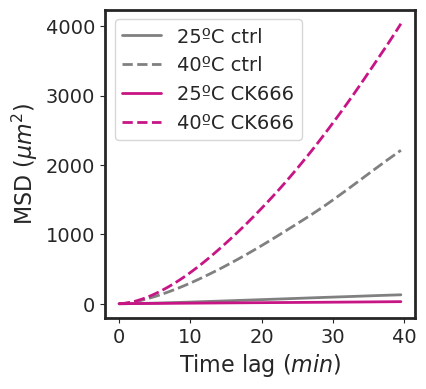

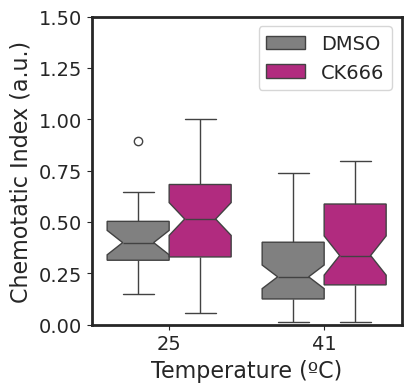

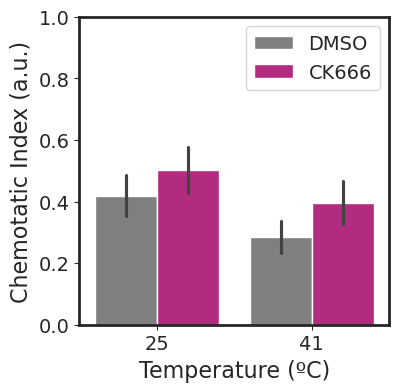

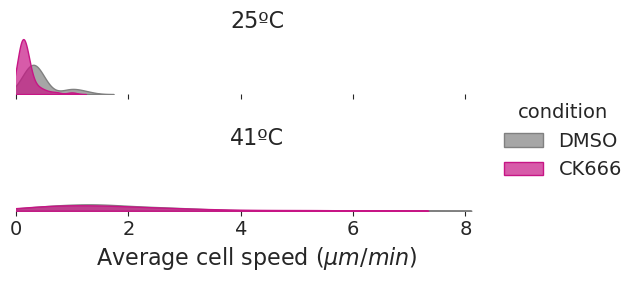

In [34]:
#SETTING THE FILES THAT WE WANT TO ANALYSE
path = ""
files = ["25_C_DMSO.csv","41_C_DMSO.csv",
         "25C_CK666.csv","41C_CK666.csv"]

files= ["Merged_Data/"+file for file in files]

conditions = ["DMSO", "DMSO", 'CK666', "CK666"]

labels = ['25', "41", "25", "41"]
colors = ['grey', 'mediumvioletred','grey', 'mediumvioletred']


pixel_conversion = 0.65
length_threshold = 160
period = 2
time_conversion = 2
cut_frames  = 0

#CALLING THE FUNCTION
main_condition(files, labels, colors, "CK666_0_80min", length_threshold, period, 
               pixel_conversion, time_conversion, conditions,cut_frames)

[0.4822697074305168, 0.24074744260755693, 0.2545517864211617, 0.3299648372522762, 0.24894594789111724, 1.6690108355528868, 0.40911526744820936, 0.246970212116098, 0.5784702571103865, 0.03631947867775399, 0.2088638274938709, 0.4099673563403178, 0.15314811579474197, 0.19563441035112816, 0.20182539822904785, 0.4093944792913826, 0.15973720019673998, 0.13191089757253296, 0.0709078745909787, 0.08938721329568772, 0.3881502343811397, 0.6648516703615083, 0.12059437040721216]
[0.9585730255446213, 0.9021893227431925, 0.30918599948367864, 0.28169265575235636, 0.2978149136479083, 0.569694915151897, 0.19521758003812384, 0.28245059195748395, 0.18101265822784895, 0.23266390029951672, 0.1943255961099803, 0.5621090896707562, 1.0433916338363673, 0.1386729908615466, 0.40333569147550946, 0.29780305553593933, 0.18350385018387308, 1.7265994069930752, 0.6971042550452009, 0.4577611528429164, 0.23405899801871016, 0.3491908923042533, 0.2282059812588825, 0.0822784810126539, 0.1751072033995556, 0.10499048124146355

/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,
/scratch/colome0000/slurm-job.23251704/ipykernel_1336824/64764151.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.lineplot(x="frame", y ="MSD", ci=68, data = df,


CI
  temperature condition   average
0          25    BLEBBI  0.486337
1          25      DMSO  0.464816
2          41    BLEBBI  0.381733
3          41      DMSO  0.373568
  temperature condition       std
0          25    BLEBBI  0.260631
1          25      DMSO  0.244142
2          41    BLEBBI  0.185849
3          41      DMSO  0.216968
  temperature condition   N
0          25    BLEBBI  37
1          25      DMSO  23
2          41    BLEBBI  46
3          41      DMSO  31
  temperature condition   average
0          25    BLEBBI  0.350495
1          25      DMSO  0.334815
2          41    BLEBBI  0.741329
3          41      DMSO  2.473011
  temperature condition       std
0          25    BLEBBI  0.334680
1          25      DMSO  0.333215
2          41    BLEBBI  0.609584
3          41      DMSO  1.660828
  temperature condition   N
0          25    BLEBBI  37
1          25      DMSO  23
2          41    BLEBBI  46
3          41      DMSO  31


0

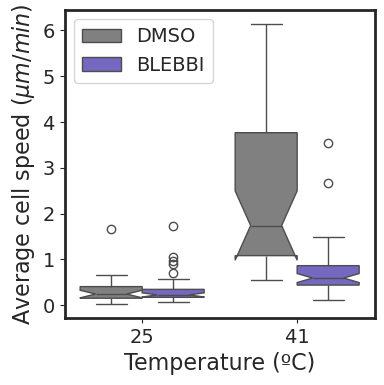

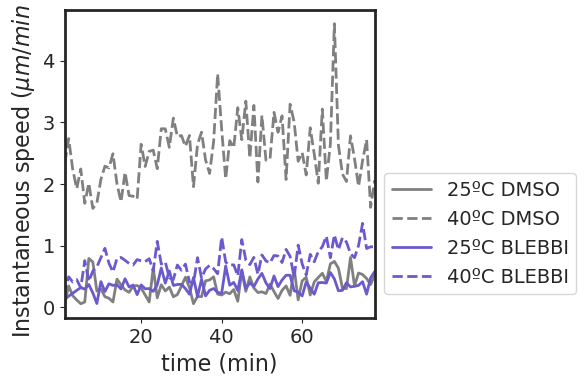

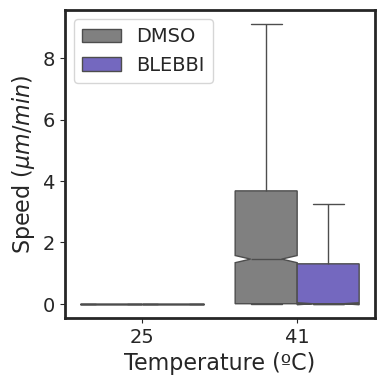

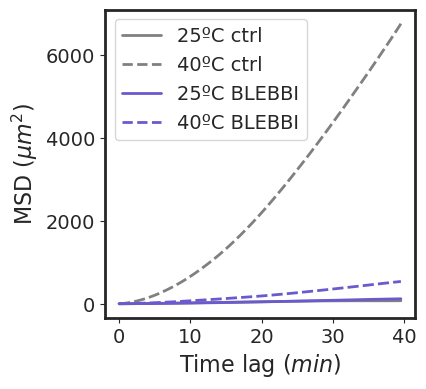

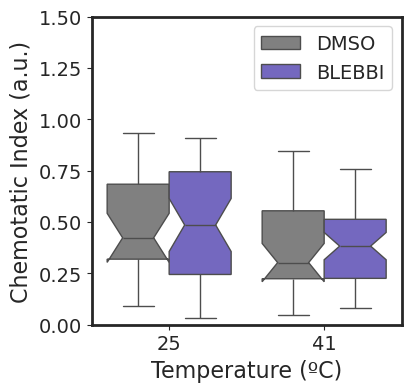

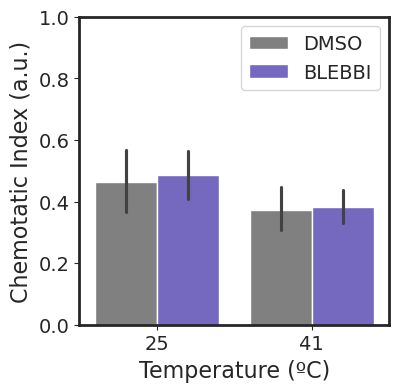

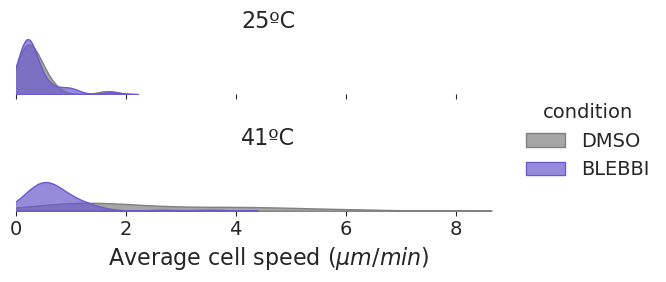

In [35]:
#SETTING THE FILES THAT WE WANT TO ANALYSE
path = ""
files = ["DMSO_25C_bleb.csv","BLEB_50uM_25C.csv",
         "DMSO_41C_bleb.csv","BLEB_50uM_41C.csv"]
conditions = ["DMSO", 'BLEBBI',"DMSO", 'BLEBBI']


files= ["Merged_Data/"+file for file in files]

labels = ["25","25",'41', "41"]
colors = ['grey', 'slateblue','grey', 'slateblue']
pixel_conversion = 0.65
length_threshold = 160
period = 2
time_conversion = 2
cut_frames  = 0

#CALLING THE FUNCTION
main_condition(files, labels, colors, "BLEBBI_0_80min", length_threshold, period, 
               pixel_conversion, time_conversion, conditions,cut_frames)

## Analysis temperature ramp

In [37]:
import os
import glob
folder_path = 'Data_ramp/Files_Ramp/'

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Convert the list to a numpy array
csv_files_array = np.array(csv_files)

# Print the numpy array
print(csv_files_array)

['Data_ramp/Files_Ramp/ts1_5 results.csv'
 'Data_ramp/Files_Ramp/perfect cells 2-5.csv'
 'Data_ramp/Files_Ramp/merged_TS1_results.csv'
 'Data_ramp/Files_Ramp/good cell 1.csv'
 'Data_ramp/Files_Ramp/Results from 1_5.csv'
 'Data_ramp/Files_Ramp/TS1_3 results.csv' 'Data_ramp/Files_Ramp/1_3.csv'
 'Data_ramp/Files_Ramp/merged_TS1_2_results.csv'
 'Data_ramp/Files_Ramp/TS1_9 results.csv'
 'Data_ramp/Files_Ramp/merge ts18_results.csv']


In [38]:
output_name = "cells.csv"

merged_df = pd.DataFrame()  # Initialize an empty DataFrame
column_names = ['Track n', 'Slice n', 'X', 'Y', 'Distance', 'Velocity', 'Pixel Value']
# Iterate through each file in the current pair/trio
for file in csv_files_array:
    df = pd.read_csv(file, encoding='ISO-8859-1')  # Read CSV
    df.columns = column_names  # Assign standardized column names
    
    if not merged_df.empty:  # If merged_df already has data, adjust 'Track n' for uniqueness
        max_track = merged_df['Track n'].max()  # Find the maximum 'Track n'
        df['Track n'] = df['Track n'] + max_track  # Ensure uniqueness in 'Track n'
    
    merged_df = pd.concat([merged_df, df], ignore_index=True)  # Merge the current DataFrame

# Save the final merged DataFrame to CSV
merged_df.to_csv("Data_ramp/"+output_name, index=False)



In [ ]:
2419/5

In [27]:
file = "Data_ramp/cells.csv"
pixel_conversion = 0.3
length_threshold = 480
# Set parameters for velocity calculation


period = 2            # Frame interval for velocity calculation
time_conversion = 2    # Conversion factor if necessary


period = 10             # Frame interval for velocity calculation
time_conversion = 0.5    # Conversion factor if necessary

x_pos, y_pos, num_cells = positions(file, pixel_conversion, length_threshold)


# Compute instantaneous velocity and associated frames
inst_velocity_list, frames_list = instant_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

In [28]:
length_threshold

480

In [29]:
def instant_velocity(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks"""
    inst_velocity_list = []
    frames_list = []
    for cell in range(num_cells):
        if len(x_pos[cell])>= length_threshold:
            for i in range((length_threshold-period)//period):
                x1 = x_pos[cell][period*i]
                x2 = x_pos[cell][period*(i+1)]
                y1 = y_pos[cell][period*i]
                y2 = y_pos[cell][period*(i+1)]
                velocity = (np.sqrt((x2-x1)**2+(y2-y1)**2))/period*time_conversion
                inst_velocity_list.append(velocity)
                frames_list.append(i/period*time_conversion)
    return inst_velocity_list, frames_list

In [30]:
import matplotlib.pyplot as plt

# Set default font family to DejaVu Sans or another available font
plt.rcParams['font.family'] = 'DejaVu Sans'

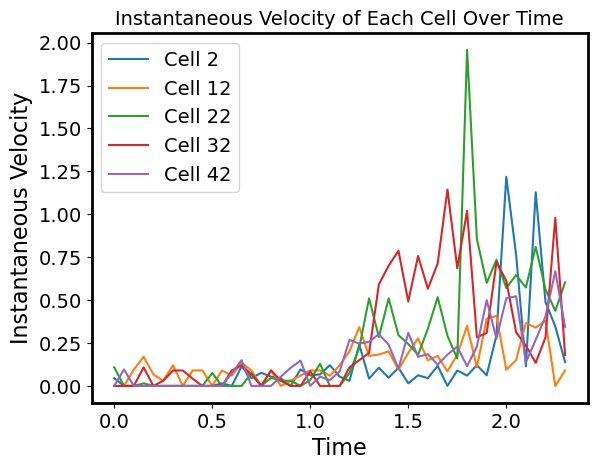

In [50]:
import numpy as np

def instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion):
    """Compute the average velocity of a set of tracks for each cell individually."""
    all_cells_velocity = []
    all_cells_frames = []
    
    for cell in range(num_cells):
        # Initialize lists to store each cell's individual velocities and frames
        cell_velocity_list = []
        cell_frames_list = []
        
        if len(x_pos[cell]) >= length_threshold:
            for i in range((len(x_pos[cell]) - period) // period):
                x1 = x_pos[cell][period * i]
                x2 = x_pos[cell][period * (i + 1)]
                y1 = y_pos[cell][period * i]
                y2 = y_pos[cell][period * (i + 1)]
                
                # Calculate velocity
                velocity = (np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) / period * time_conversion
                cell_velocity_list.append(velocity)
                
                # Calculate the corresponding time frame for the velocity
                frame_time = i / period * time_conversion
                cell_frames_list.append(frame_time)
        if (cell!=31):
            # Append each cell's velocity and frames to the main list
            all_cells_velocity.append(cell_velocity_list)
            all_cells_frames.append(cell_frames_list)

    return all_cells_velocity, all_cells_frames


import matplotlib.pyplot as plt

# Assuming `instant_velocity` is run and returns `all_cells_velocity` and `all_cells_frames`
all_cells_velocity, all_cells_frames = instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

# Plot the velocity over time for each cell
cell_indexs = [1,11,21,31,41]
#for cell_index in range(len(all_cells_frames)):
for cell_index in cell_indexs:

    plt.plot(all_cells_frames[cell_index], all_cells_velocity[cell_index], label=f'Cell {cell_index + 1}')

plt.xlabel('Time')
plt.ylabel('Instantaneous Velocity')
plt.title('Instantaneous Velocity of Each Cell Over Time')
plt.legend()
plt.show()


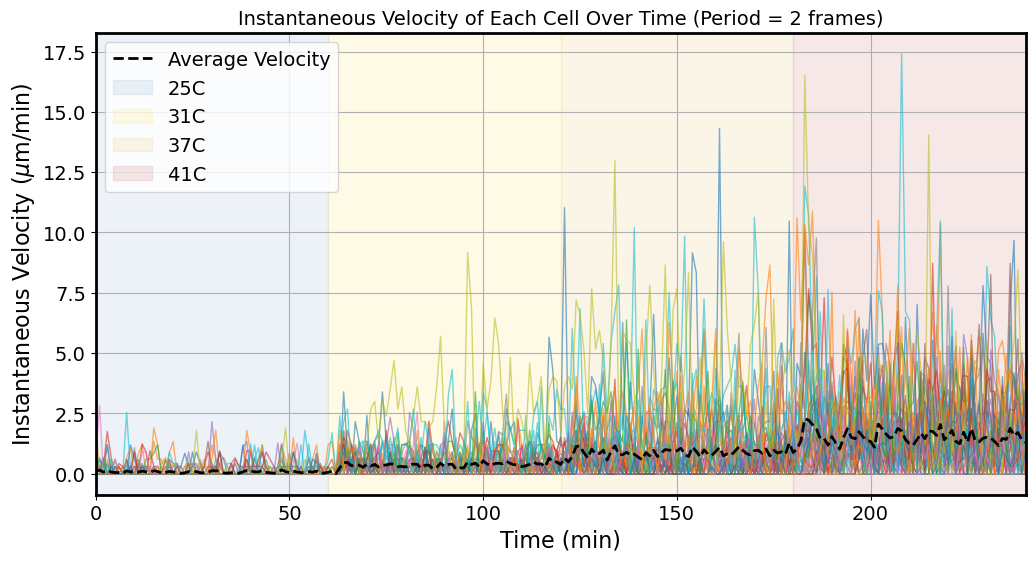

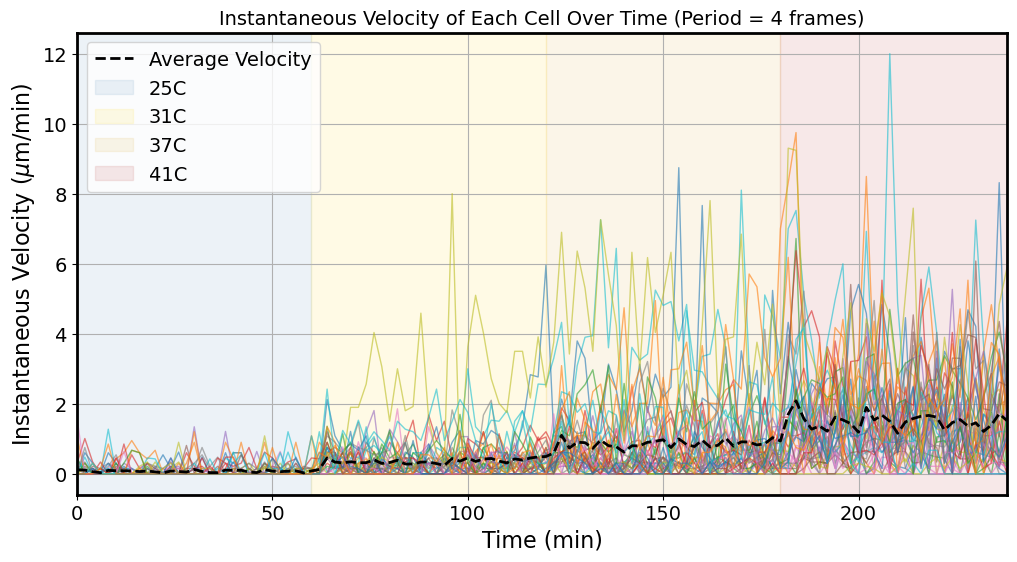

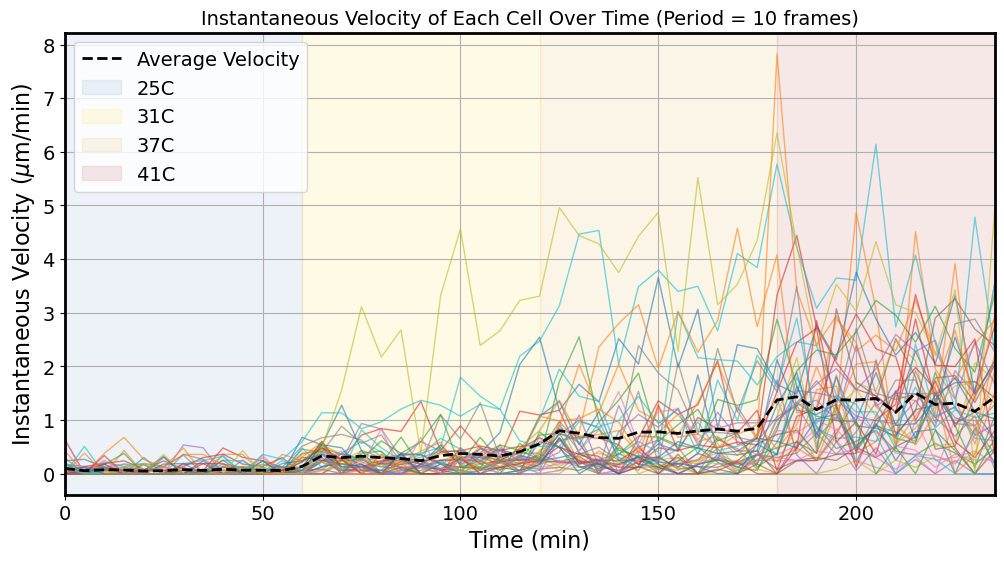

In [62]:

# Conversion factors
periods = [2, 4, 10]  # 1 min, 2 min, and 5 min (frames)
time_conversions = [ 0.5,  0.5, 0.5]  # Corresponding time conversion for each period

for period, time_conversion in zip(periods, time_conversions):
    # Compute instantaneous velocity and associated frames
    all_cells_velocity, all_cells_frames = instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

    # Prepare data for plotting
    data = {
        'Cell ID': [],
        'Time': [],
        'Velocity': []
    }

    for cell_index in range(len(all_cells_velocity)):
        cell_id = f'Cell {cell_index + 1}'
        times = all_cells_frames[cell_index]
        velocities = all_cells_velocity[cell_index]
        
        data['Cell ID'].extend([cell_id] * len(times))
        data['Time'].extend(times)
        data['Velocity'].extend(velocities)

    df_velocity = pd.DataFrame(data)

    # Plotting
    fig = plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_velocity, x='Time', y='Velocity', hue='Cell ID', palette='tab10', linewidth=1, alpha=0.6, legend=None)

    # Plot average velocity
    avg_velocity = df_velocity.groupby('Time')['Velocity'].mean().reset_index()
    sns.lineplot(data=avg_velocity, x='Time', y='Velocity', color='black', linewidth=2, linestyle='--', label='Average Velocity')

    # Highlight temperature zones (if applicable)
    plt.axvspan(0, 60, color='steelblue', alpha=0.1, label='25C')
    plt.axvspan(60, 120, color='gold', alpha=0.1, label='31C')
    plt.axvspan(120, 180, color='goldenrod', alpha=0.1, label='37C')
    plt.axvspan(180, 240, color='firebrick', alpha=0.1, label='41C')

    plt.xlim(0, max(avg_velocity['Time']))
    plt.xlabel('Time (min)')
    plt.ylabel('Instantaneous Velocity ($\mu$m/min)')
    plt.title(f'Instantaneous Velocity of Each Cell Over Time (Period = {period} frames)')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Save figure
    fig.savefig(f"Data_ramp/Inst_velocity_{period}min.png", dpi=200, bbox_inches='tight', transparent=True)
    fig.savefig(f"Data_ramp/Inst_velocity_{period}min.svg", bbox_inches='tight', transparent=True)

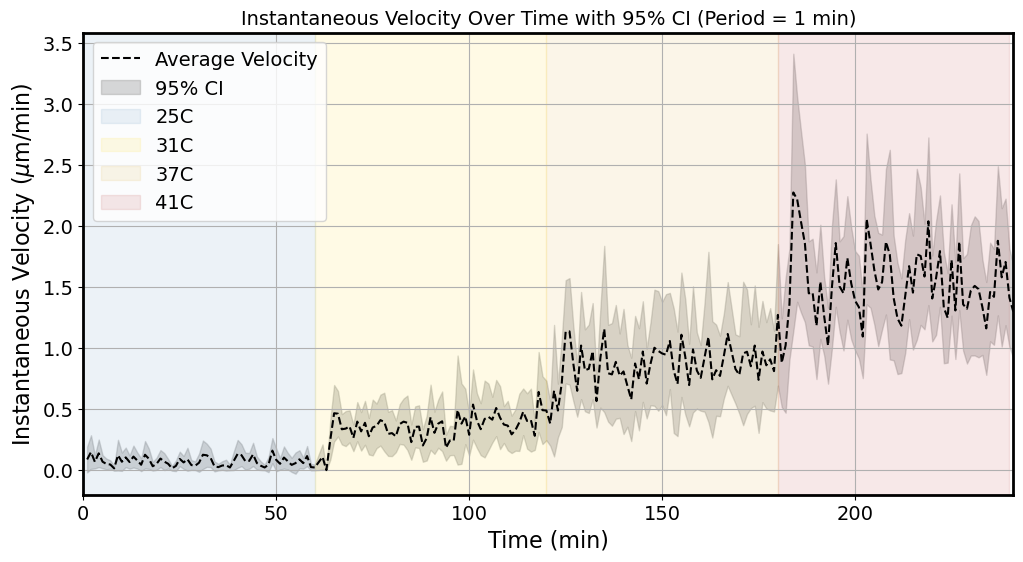

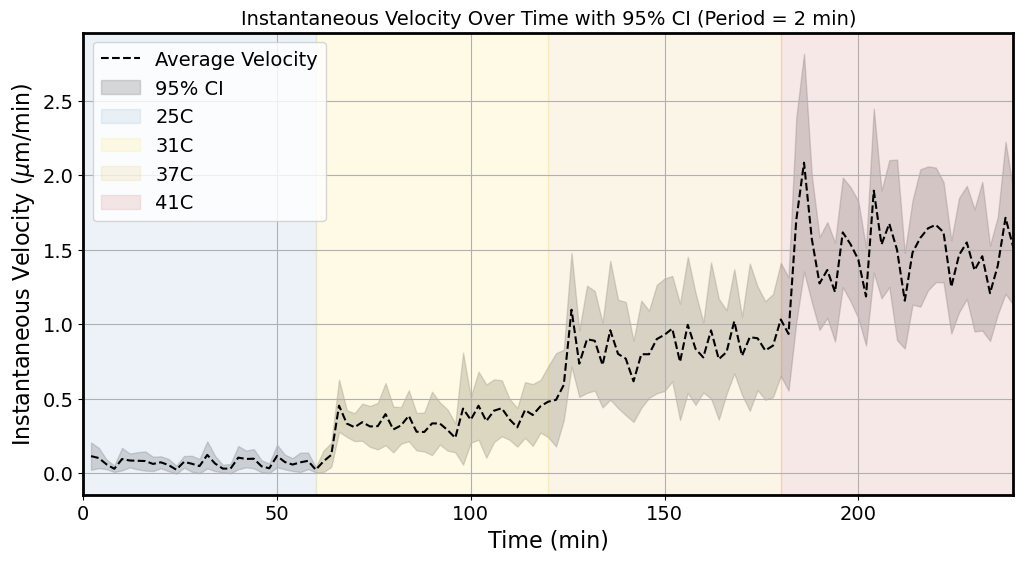

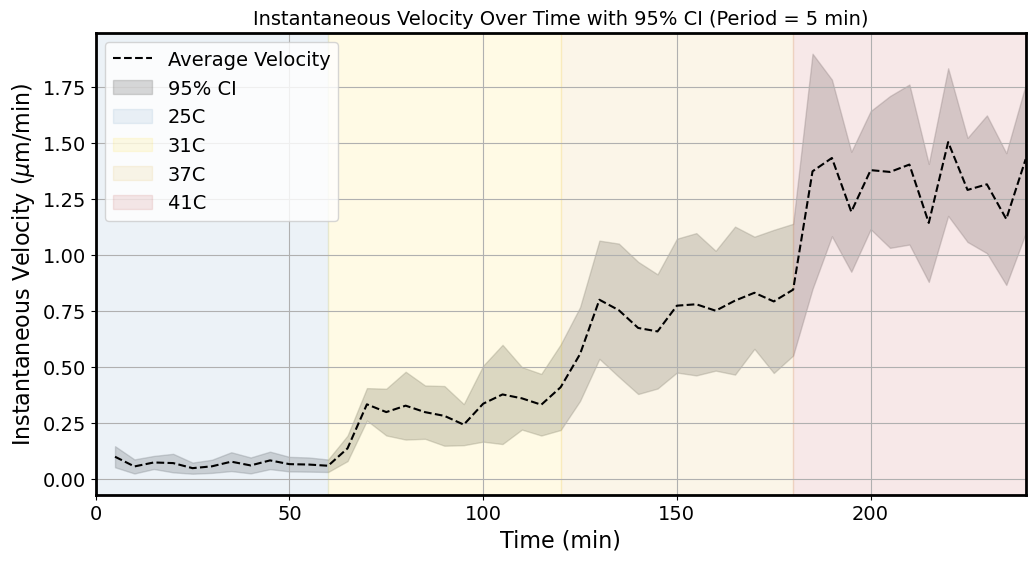

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define periods in frames and their corresponding equivalent in minutes
periods = [2, 4, 10]  # Frame intervals (1 min, 2 min, 5 min)
time_conversions = [0.5, 0.5, 0.5]  # Consistent time conversion across periods
minutes_equivalent = [1, 2, 5]  # Equivalent time in minutes for each period

for period, time_conversion, minutes in zip(periods, time_conversions, minutes_equivalent):
    # Calculate velocities and frames for each period
    all_cells_velocity, all_cells_frames = instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

    # Prepare data for trend and confidence interval calculation
    data = {'Time': [], 'Velocity': []}
    for cell_index in range(len(all_cells_velocity)):
        times = all_cells_frames[cell_index]
        velocities = all_cells_velocity[cell_index]
        data['Time'].extend(times)
        data['Velocity'].extend(velocities)

    df_velocity = pd.DataFrame(data)

    # Compute mean and 95% confidence interval
    avg_velocity = df_velocity.groupby('Time')['Velocity'].mean().reset_index()
    ci_velocity = df_velocity.groupby('Time')['Velocity'].agg(['mean', 'std']).reset_index()
    ci_velocity['ci_upper'] = ci_velocity['mean'] + 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))
    ci_velocity['ci_lower'] = ci_velocity['mean'] - 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))

    # Plot mean with confidence interval
    fig = plt.figure(figsize=(12, 6))
    plt.plot(avg_velocity['Time'], avg_velocity['Velocity'], color='black', linestyle='--', label='Average Velocity')
    plt.fill_between(ci_velocity['Time'], ci_velocity['ci_lower'], ci_velocity['ci_upper'], color='gray', alpha=0.3, label='95% CI')

    # Highlight temperature zones
    plt.axvspan(0, 60, color='steelblue', alpha=0.1, label='25C')
    plt.axvspan(60, 120, color='gold', alpha=0.1, label='31C')
    plt.axvspan(120, 180, color='goldenrod', alpha=0.1, label='37C')
    plt.axvspan(180, 240, color='firebrick', alpha=0.1, label='41C')

    # Final plot adjustments
    plt.xlim(0, max(avg_velocity['Time']))
    plt.xlabel('Time (min)')
    plt.ylabel('Instantaneous Velocity ($\mu$m/min)')
    plt.title(f'Instantaneous Velocity Over Time with 95% CI (Period = {minutes} min)')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the plot
    fig.savefig(f"Data_ramp/Inst_velocity_{minutes}min_trend_CI.png", dpi=200, bbox_inches='tight', transparent=True)
    fig.savefig(f"Data_ramp/Inst_velocity_{minutes}min_trend_CI.svg", bbox_inches='tight', transparent=True)


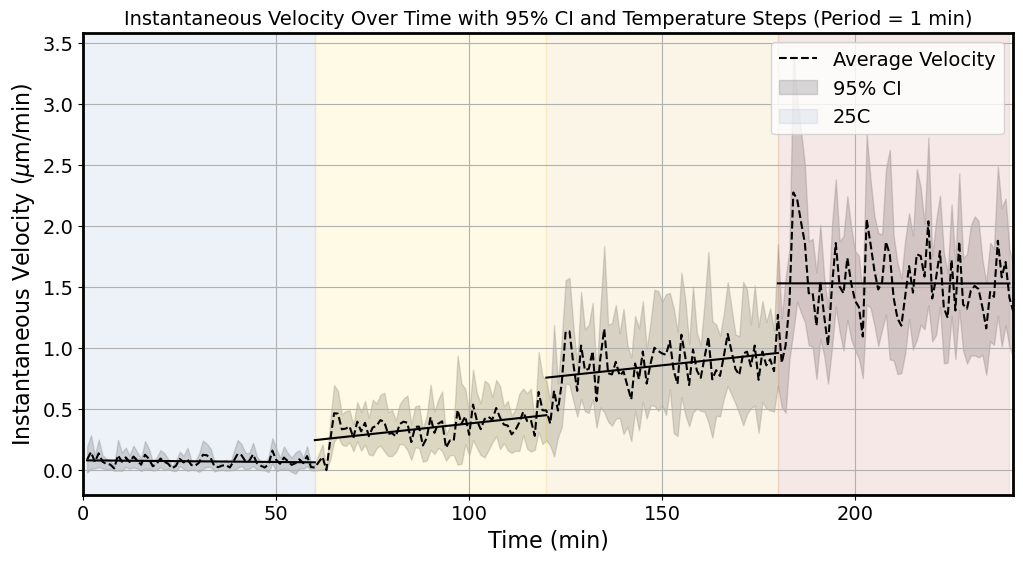

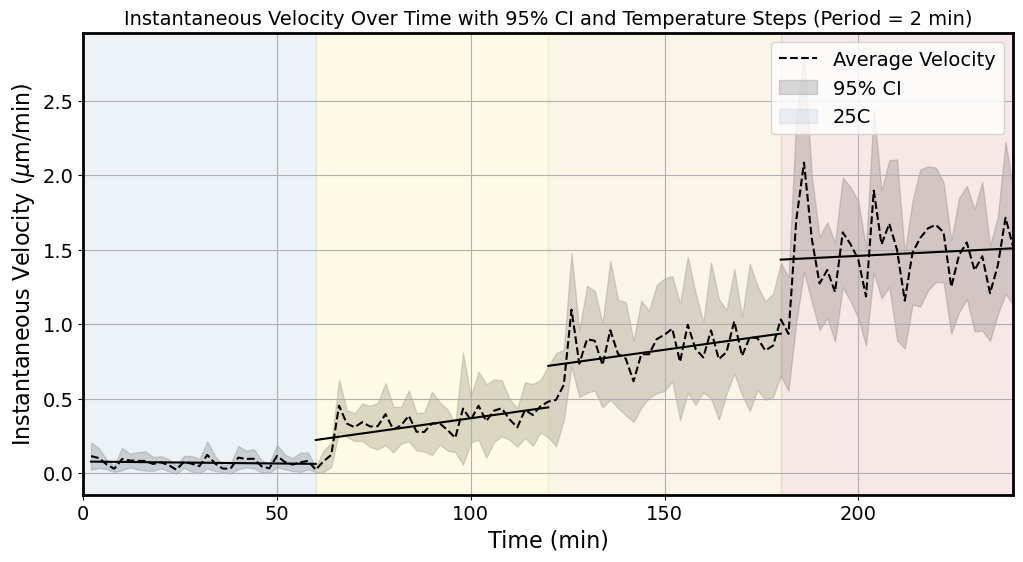

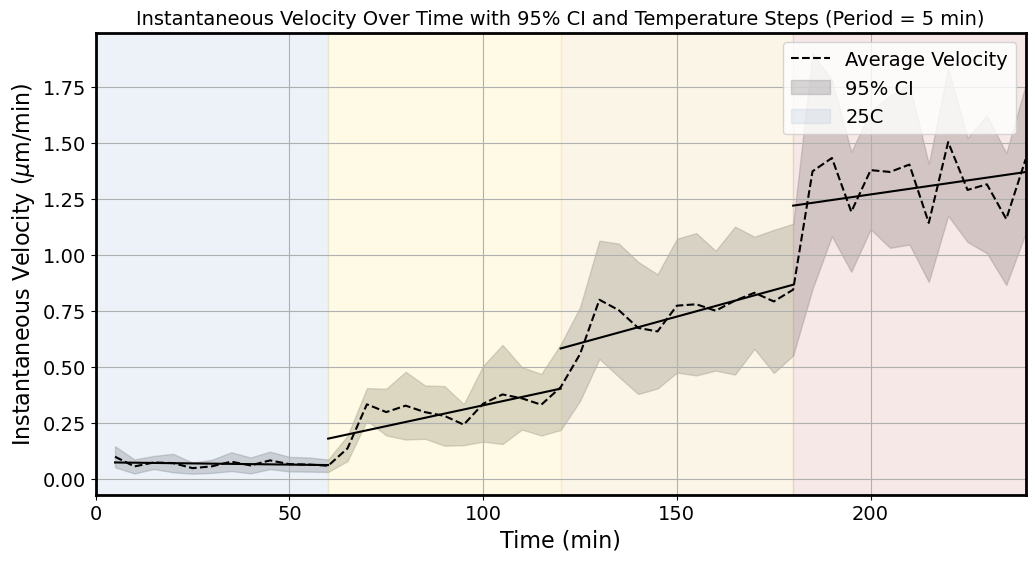

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define periods in frames and their corresponding equivalent in minutes
periods = [2, 4, 10]  # Frame intervals (1 min, 2 min, 5 min)
time_conversions = [0.5, 0.5, 0.5]  # Consistent time conversion across periods
minutes_equivalent = [1, 2, 5]  # Equivalent time in minutes for each period

# Define temperature zones
temperature_zones = [(0, 60, '25C'), (60, 120, '31C'), (120, 180, '37C'), (180, 240, '41C')]

for period, time_conversion, minutes in zip(periods, time_conversions, minutes_equivalent):
    # Calculate velocities and frames for each period
    all_cells_velocity, all_cells_frames = instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

    # Prepare data for trend and confidence interval calculation
    data = {'Time': [], 'Velocity': []}
    for cell_index in range(len(all_cells_velocity)):
        times = all_cells_frames[cell_index]
        velocities = all_cells_velocity[cell_index]
        data['Time'].extend(times)
        data['Velocity'].extend(velocities)

    df_velocity = pd.DataFrame(data)

    # Compute mean and 95% confidence interval
    avg_velocity = df_velocity.groupby('Time')['Velocity'].mean().reset_index()
    ci_velocity = df_velocity.groupby('Time')['Velocity'].agg(['mean', 'std']).reset_index()
    ci_velocity['ci_upper'] = ci_velocity['mean'] + 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))
    ci_velocity['ci_lower'] = ci_velocity['mean'] - 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))

    # Plot mean with confidence interval
    fig = plt.figure(figsize=(12, 6))
    plt.plot(avg_velocity['Time'], avg_velocity['Velocity'], color='black', linestyle='--', label='Average Velocity')
    plt.fill_between(ci_velocity['Time'], ci_velocity['ci_lower'], ci_velocity['ci_upper'], color='gray', alpha=0.3, label='95% CI')

    # Highlight temperature zones and add linear fit
    for start, end, temp_label in temperature_zones:
        plt.axvspan(start, end, color='steelblue' if temp_label == '25C' else 'gold' if temp_label == '31C' else 'goldenrod' if temp_label == '37C' else 'firebrick', alpha=0.1, label=temp_label if start == 0 else "")
        
        # Subset data for each temperature zone and compute linear fit
        zone_data = avg_velocity[(avg_velocity['Time'] >= start) & (avg_velocity['Time'] <= end)]
        if not zone_data.empty:
            slope, intercept, _, _, _ = linregress(zone_data['Time'], zone_data['Velocity'])
            plt.plot(zone_data['Time'], intercept + slope * zone_data['Time'], linestyle='-', color='black')

    # Final plot adjustments
    plt.xlim(0, max(avg_velocity['Time']))
    plt.xlabel('Time (min)')
    plt.ylabel('Instantaneous Velocity ($\mu$m/min)')
    plt.title(f'Instantaneous Velocity Over Time with 95% CI and Temperature Steps (Period = {minutes} min)')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the plot
    fig.savefig(f"Data_ramp/Inst_velocity_{minutes}min_trend_CI_temp_fit.png", dpi=200, bbox_inches='tight', transparent=True)
    fig.savefig(f"Data_ramp/Inst_velocity_{minutes}min_trend_CI_temp_fit.svg", bbox_inches='tight', transparent=True)


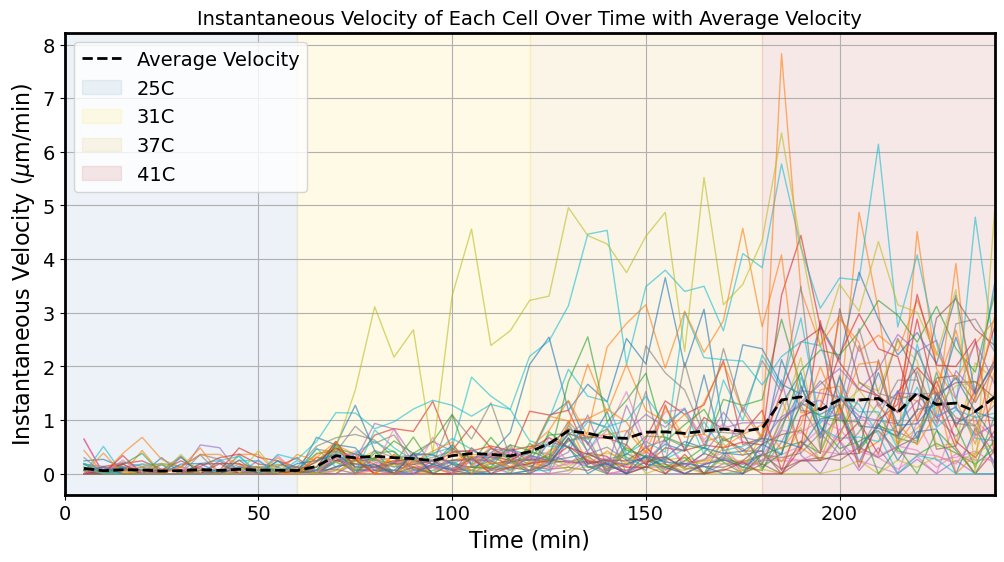

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert all_cells_velocity and all_cells_frames to a DataFrame
data = {
    'Cell ID': [],
    'Time': [],
    'Velocity': []
}

for cell_index in range(len(all_cells_velocity)):
    cell_id = f'Cell {cell_index + 1}'
    times = all_cells_frames[cell_index]
    velocities = all_cells_velocity[cell_index]
    
    data['Cell ID'].extend([cell_id] * len(times))
    data['Time'].extend(times)
    data['Velocity'].extend(velocities)

# Create DataFrame
df_velocity = pd.DataFrame(data)
df_velocity['Time'] = df_velocity['Time']
# Plot with Seaborn
fig = plt.figure(figsize=(12, 6))
sns.lineplot(data=df_velocity, x='Time', y='Velocity', hue='Cell ID', palette='tab10', linewidth=1, alpha=0.6, legend=None)

# Plot the average velocity as a separate line
avg_velocity = df_velocity.groupby('Time')['Velocity'].mean().reset_index()
sns.lineplot(data=avg_velocity, x='Time', y='Velocity', color='black', linewidth=2, linestyle='--', label='Average Velocity')


colors = ['steelblue', 'goldenrod', 'firebrick']


plt.axvspan(0, 60, color='steelblue', alpha=0.1, label='25C')
plt.axvspan(60, 120, color='gold', alpha=0.1, label='31C')
plt.axvspan(120, 180, color='goldenrod', alpha=0.1, label='37C')
plt.axvspan(180, 240, color='firebrick', alpha=0.1, label='41C')

plt.xlim(0,240)
#plt.ylim(-1,10)
plt.xlabel('Time (min)')
plt.ylabel('Instantaneous Velocity ($\mu $m/min)')
plt.title('Instantaneous Velocity of Each Cell Over Time with Average Velocity')
plt.legend()
plt.grid()
plt.show()


fig.savefig("Data_ramp/Inst_velocity_5min.svg", bbox_inches='tight', transparent=True)
fig.savefig("Data_ramp/Inst_velocity_5min.png", dpi=200, bbox_inches='tight', transparent=True)



Period Step: 1 min
Temperature Step: 25C
Mean Velocity: 0.072
Standard Deviation: 0.037
Standard Error of the Mean (SEM): 0.006
N (Sample Size): 43
------------------------------
Period Step: 1 min
Temperature Step: 31C
Mean Velocity: 0.348
Standard Deviation: 0.118
Standard Error of the Mean (SEM): 0.018
N (Sample Size): 43
------------------------------
Period Step: 1 min
Temperature Step: 37C
Mean Velocity: 0.859
Standard Deviation: 0.174
Standard Error of the Mean (SEM): 0.027
N (Sample Size): 43
------------------------------
Period Step: 1 min
Temperature Step: 41C
Mean Velocity: 1.531
Standard Deviation: 0.291
Standard Error of the Mean (SEM): 0.044
N (Sample Size): 43
------------------------------


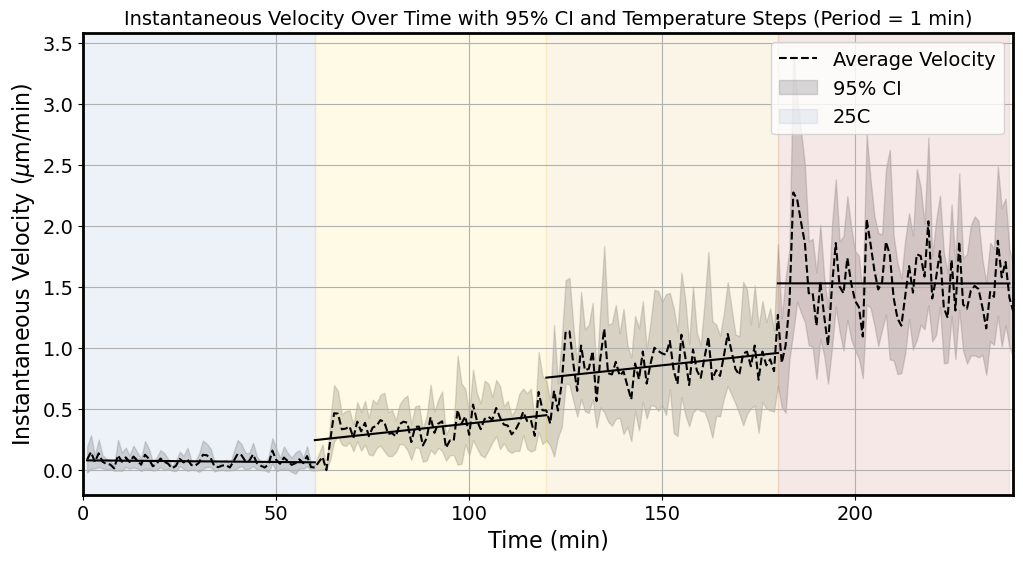

Period Step: 2 min
Temperature Step: 25C
Mean Velocity: 0.070
Standard Deviation: 0.029
Standard Error of the Mean (SEM): 0.004
N (Sample Size): 43
------------------------------
Period Step: 2 min
Temperature Step: 31C
Mean Velocity: 0.332
Standard Deviation: 0.106
Standard Error of the Mean (SEM): 0.016
N (Sample Size): 43
------------------------------
Period Step: 2 min
Temperature Step: 37C
Mean Velocity: 0.828
Standard Deviation: 0.147
Standard Error of the Mean (SEM): 0.022
N (Sample Size): 43
------------------------------
Period Step: 2 min
Temperature Step: 41C
Mean Velocity: 1.471
Standard Deviation: 0.243
Standard Error of the Mean (SEM): 0.037
N (Sample Size): 43
------------------------------


<Figure size 640x480 with 0 Axes>

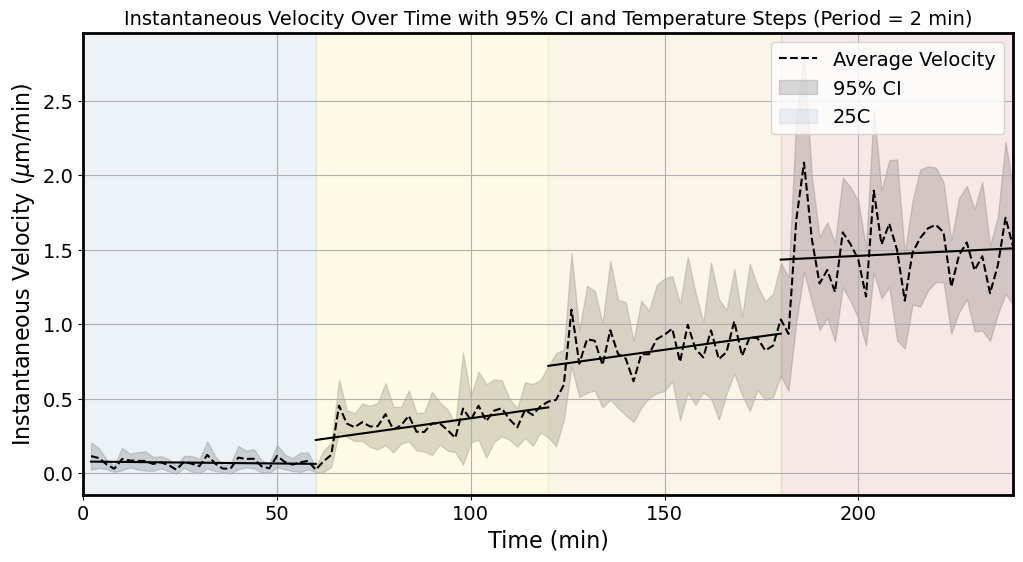

Period Step: 5 min
Temperature Step: 25C
Mean Velocity: 0.068
Standard Deviation: 0.014
Standard Error of the Mean (SEM): 0.002
N (Sample Size): 43
------------------------------
Period Step: 5 min
Temperature Step: 31C
Mean Velocity: 0.292
Standard Deviation: 0.097
Standard Error of the Mean (SEM): 0.015
N (Sample Size): 43
------------------------------
Period Step: 5 min
Temperature Step: 37C
Mean Velocity: 0.725
Standard Deviation: 0.123
Standard Error of the Mean (SEM): 0.019
N (Sample Size): 43
------------------------------
Period Step: 5 min
Temperature Step: 41C
Mean Velocity: 1.296
Standard Deviation: 0.175
Standard Error of the Mean (SEM): 0.027
N (Sample Size): 43
------------------------------


<Figure size 640x480 with 0 Axes>

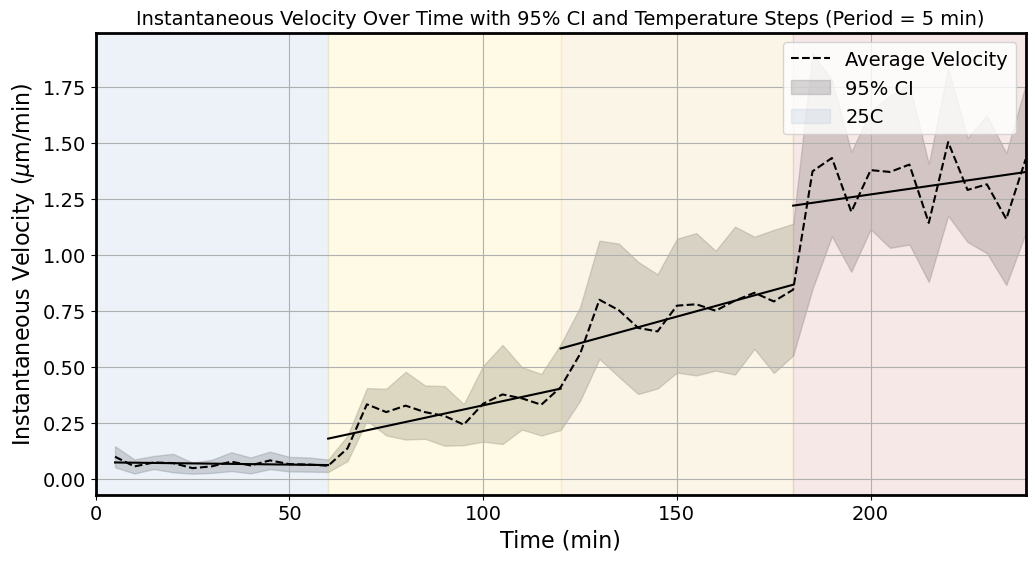

<Figure size 640x480 with 0 Axes>

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define periods in frames and their corresponding equivalent in minutes
periods = [2, 4, 10]  # Frame intervals (1 min, 2 min, 5 min)
time_conversions = [0.5, 0.5, 0.5]  # Consistent time conversion across periods
minutes_equivalent = [1, 2, 5]  # Equivalent time in minutes for each period

# Define temperature zones
temperature_zones = [(0, 60, '25C'), (60, 120, '31C'), (120, 180, '37C'), (180, 240, '41C')]

for period, time_conversion, minutes in zip(periods, time_conversions, minutes_equivalent):
    # Calculate velocities and frames for each period
    all_cells_velocity, all_cells_frames = instant_velocity_ramp(x_pos, y_pos, num_cells, length_threshold, period, time_conversion)

    # Prepare data for trend and confidence interval calculation
    data = {'Time': [], 'Velocity': []}
    for cell_index in range(len(all_cells_velocity)):
        times = all_cells_frames[cell_index]
        velocities = all_cells_velocity[cell_index]
        data['Time'].extend(times)

        data['Velocity'].extend(velocities)

    df_velocity = pd.DataFrame(data)
    # Compute mean and 95% confidence interval
    avg_velocity = df_velocity.groupby('Time')['Velocity'].mean().reset_index()
    ci_velocity = df_velocity.groupby('Time')['Velocity'].agg(['mean', 'std']).reset_index()
    ci_velocity['ci_upper'] = ci_velocity['mean'] + 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))
    ci_velocity['ci_lower'] = ci_velocity['mean'] - 1.96 * (ci_velocity['std'] / np.sqrt(num_cells))

    # Plot mean with confidence interval
    plt.figure(figsize=(12, 6))
    plt.plot(avg_velocity['Time'], avg_velocity['Velocity'], color='black', linestyle='--', label='Average Velocity')
    plt.fill_between(ci_velocity['Time'], ci_velocity['ci_lower'], ci_velocity['ci_upper'], color='gray', alpha=0.3, label='95% CI')

    # Highlight temperature zones and add linear fit, and calculate stats for each zone
    for start, end, temp_label in temperature_zones:
        plt.axvspan(start, end, color='steelblue' if temp_label == '25C' else 'gold' if temp_label == '31C' else 'goldenrod' if temp_label == '37C' else 'firebrick', alpha=0.1, label=temp_label if start == 0 else "")
        
        # Subset data for each temperature zone and compute linear fit
        zone_data = avg_velocity[(avg_velocity['Time'] >= start) & (avg_velocity['Time'] <= end)]
        if not zone_data.empty:
            # Linear fit
            slope, intercept, _, _, _ = linregress(zone_data['Time'], zone_data['Velocity'])
            plt.plot(zone_data['Time'], intercept + slope * zone_data['Time'], linestyle='-', color='black')
            
            # Calculate and print stats
            mean_velocity = zone_data['Velocity'].mean()
            std_velocity = zone_data['Velocity'].std()
            sem_velocity = std_velocity / np.sqrt(num_cells)
            n = len(zone_data)
            print(f"Period Step: {minutes} min")

            print(f"Temperature Step: {temp_label}")
            print(f"Mean Velocity: {mean_velocity:.3f}")
            print(f"Standard Deviation: {std_velocity:.3f}")
            print(f"Standard Error of the Mean (SEM): {sem_velocity:.3f}")
            print(f"N (Sample Size): {num_cells}")
            print("-" * 30)

    # Final plot adjustments
    plt.xlim(0, max(avg_velocity['Time']))
    plt.xlabel('Time (min)')
    plt.ylabel('Instantaneous Velocity ($\mu$m/min)')
    plt.title(f'Instantaneous Velocity Over Time with 95% CI and Temperature Steps (Period = {minutes} min)')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the plot
    plt.savefig(f"Data_ramp/Inst_velocity_{minutes}min_trend_CI_temp_fit.png", dpi=200, bbox_inches='tight', transparent=True)


### Intracellular calcium level

In [ ]:

df_intra = pd.read_csv("CSV data/intracellular.csv", encoding = "ISO-8859-1")
df_intra = df_intra.rename(columns = {'25C NORM': '$RT_2$', 'Negative control': 'Neg ctrl',
                          '25C NORM control': '$RT_1$', '45C NORM': '40ºC'}, inplace = False)
df_intra = pd.melt(df_intra)
df_intra.dropna()
df_intra = df_intra.dropna()
colors = ['slategrey', 'indianred', 'slategrey', "moccasin"]

customPalette = sns.set_palette(sns.color_palette(colors))
df_intra['value'] = df_intra['value'].astype('float')

print(df_intra.groupby('variable')['value'].mean().reset_index(name='average'))
print(df_intra.groupby('variable')['value'].std().reset_index(name='std'))
print(df_intra.groupby('variable')['value'].size().reset_index(name='N'))


figIntra = plt.figure(1,figsize=(4,4))
ax = sns.boxplot(x="variable", y ="value",data = df_intra,  palette = customPalette, width= 0.8, notch=True, showfliers=False)
plt.xlabel('')
plt.ylabel('Calbryte concentration (AU)')
plt.ylim(0,2.5)

add_stat_annotation(ax, data=df_intra, x="variable", y="value",
                box_pairs=[('40ºC','Neg ctrl' )],text_annot_custom=["ns"],
                               pvalues=[0], loc="inside",perform_stat_test=False,line_height=0.0,line_offset_to_box=-0.3)

    
#ax.grid(b=True, which='minor', color='w', linewidth=0.5)
sns.set_style("ticks", {"xtick.major.size": 45, "ytick.major.size": 45})

figIntra.savefig("SVG/"+"intracellular.svg", bbox_inches='tight', transparent=True)
figIntra.savefig("PNG/"+"intracellular.png", dpi=200, bbox_inches='tight', transparent=True)

